In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Overview
The goal of this project is to build a GAN model that reads in Monet and photographs, then adjusts the photographs to be in a Monet style.

The approach of this notebook will be to import python packages, read in the Monet pics and photographs, and perform a quick exploratory data analysis (EDA).  The modeling approach will be a CycleGAN model, which is a GAN model that doesn't require images to be paired.  Reference for CycleGAN Model: https://machinelearningmastery.com/what-is-cyclegan/.  Then will look at some sample photos and submit the final image files to Kaggle.  

### Import Packages

In [35]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
#import tensorflow_addons as tfa
import keras
from keras import layers
from keras import ops

import PIL
import shutil
import zipfile
from PIL import Image

### Import Monet and photograph pictures
Read in Monet and photographs from different folders, decode the images, and store them in different datasets.

In [1]:
#Input picture paths
monet_jpg_path = '../input/gan-getting-started/monet_jpg'
photo_jpg_path = '../input/gan-getting-started/photo_jpg'


In [4]:
def image_path(path):
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names

In [5]:
monet_jpg = image_path(monet_jpg_path)
photo_jpg = image_path(photo_jpg_path)

#check that directories have file names in them
print('Number of files in Monet Dir: ' + str(len(monet_jpg)))
print('Number of files in Photo Dir: ' + str(len(photo_jpg)))

Number of files in Monet Dir: 300
Number of files in Photo Dir: 7038


In [6]:
monet_tfrec_path = tf.io.gfile.glob('../input/gan-getting-started/monet_tfrec/*.tfrec')
photo_tfrec_path = tf.io.gfile.glob('../input/gan-getting-started/photo_tfrec/*.tfrec')

In [7]:
# Functions for loading in TFREC datasets with images

IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

In [8]:
#Load Monet and Photo pictures from paths
monet_tfrec = load_dataset(monet_tfrec_path, labeled=True).batch(1)
photo_tfrec = load_dataset(photo_tfrec_path, labeled=True).batch(1)

#check that directories have file names in them
print('Number Monet files: ' + str(len(list(monet_tfrec))))
print('Number Photo files: ' + str(len(list(photo_tfrec))))

Number Monet files: 300
Number Photo files: 7038


### EDA
Check that the there are 300 Monet and 7k photographs.  Along with looking at a few samples of both Monet and the photographs.  Confirming Monet pics are Monet paintings and photographs are indeeed non-monet photographs

In [9]:
#check that directories have file names in them
print('Number Monet files: ' + str(len(list(monet_tfrec))))
print('Number Photo files: ' + str(len(list(photo_tfrec))))

Number Monet files: 300
Number Photo files: 7038


In [10]:
def display(images_paths, rows, cols):
    figure, ax = plt.subplots(nrows=rows,ncols=cols,figsize=(16,8) )
    for ind,image_path in enumerate(images_paths):
        image=cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        try:
            ax.ravel()[ind].imshow(image)
            ax.ravel()[ind].set_axis_off()
        except:
            continue;
    plt.tight_layout()
    plt.show()

Sample Monet pictutes


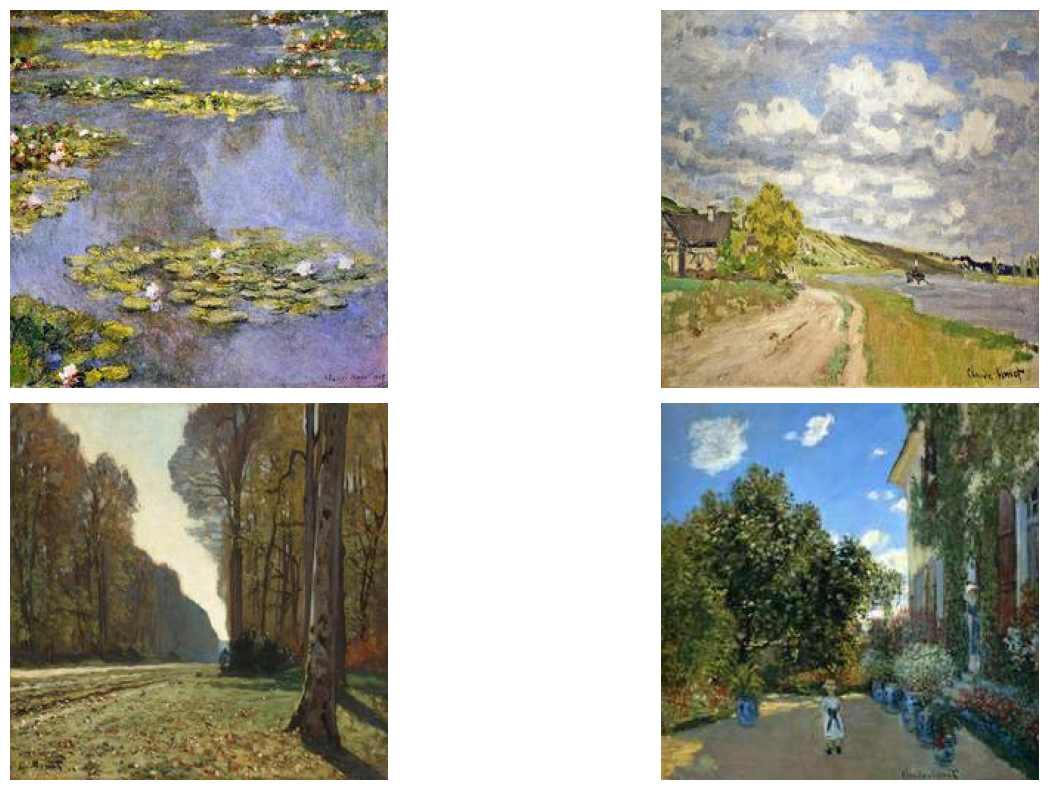

In [11]:
print('Sample Monet pictutes')
display(monet_jpg, 2, 2)

Sample Photo pictures


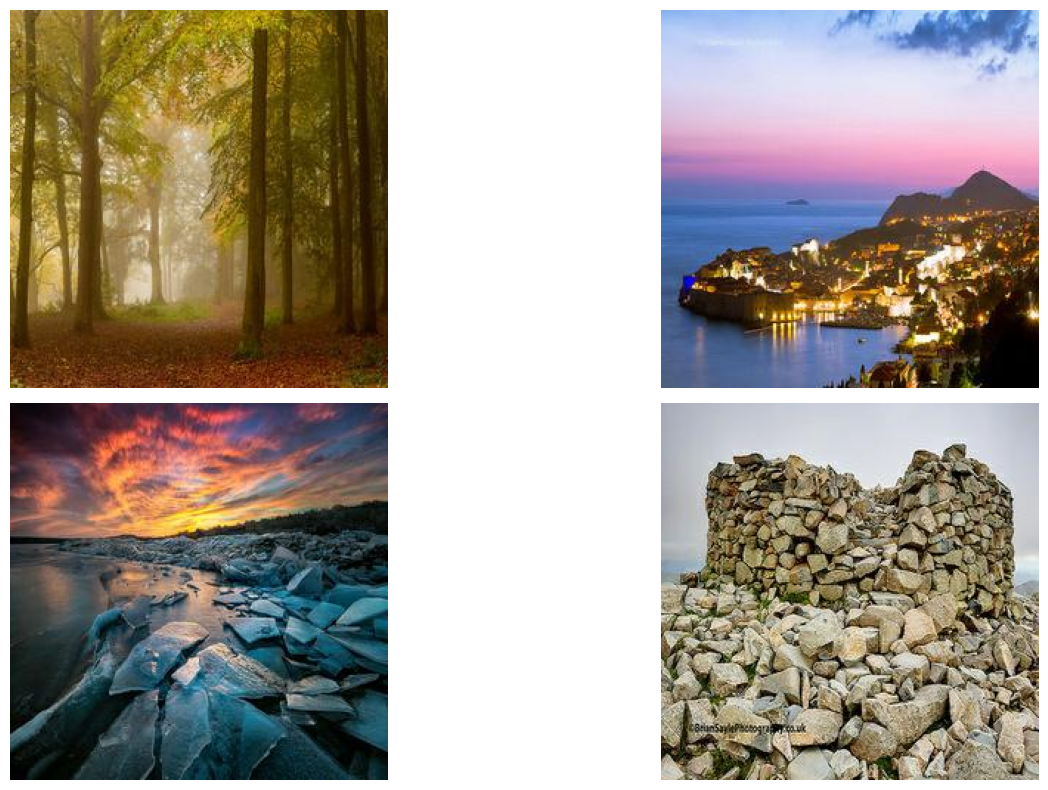

In [12]:
print('Sample Photo pictures')
display(photo_jpg, 2, 2)

### Modeling Section
Set up a Generator and Discrimintor models for a CycleGAN model approach.  The loss function will be the BinaryCrossentropy.  The generator model is a 7 layer decoder and 7 layer encoder.  The discriminator model also has 7 layers.  I tested a few different learning rates around 3e-5 and landed on 3e-5 as my the final learning rate.  Used beta at 0.5.  Kept the epochs to a low number of 5 mainly to save time when running the model, since more of the development was done with CPUs due to issues using GPUs.  Earlier tests ran with 1-2 epochs to ensure the model would run.


### Generator

In [13]:
# Source: Jang, A., Monet CycleGAN Tutorial.
# https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
    
    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    
    result.add(layers.LeakyReLU())
    
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
    
    result = keras.Sequential()
    result.add(layers.UpSampling2D())
    result.add(layers.Conv2D(filters, size, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    
    result.add(layers.ReLU())
    
    return result

In [14]:
def Generator():
    inputs = layers.Input(shape=[256, 256, 3])

    # Define encoder layers
    encoder_layers = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    # Define decoder layers
    decoder_layers = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                strides=2,
                                padding='same',
                                kernel_initializer=initializer,
                                activation='tanh')  # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the encoder
    skips = []
    for down in encoder_layers:
        x = down(x)
        skips.append(x)

    skips = list(reversed(skips[:-1]))

    # Upsampling and establishing the skip connections
    for up, skip in zip(decoder_layers, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

### Discriminator

In [15]:
def Discriminator():
    
    inputs = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inputs

    # Downsampling layers
    x = downsample(64, 4, apply_batchnorm=False)(x)  # (bs, 128, 128, 64)
    x = downsample(128, 4)(x)  # (bs, 64, 64, 128)
    x = downsample(256, 4)(x)  # (bs, 32, 32, 256)

    # Convolutional layer
    x = layers.Conv2D(512, 4, strides=1, padding='valid',
                    kernel_initializer=tf.random_normal_initializer(0., 0.02),
                    use_bias=False)(x)  # (bs, 29, 29, 512)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    # Output layer
    output = layers.Conv2D(1, 4, strides=1, padding='valid',
                        kernel_initializer=tf.random_normal_initializer(0., 0.02))(x)  # (bs, 26, 26, 1)

    return keras.Model(inputs=inputs, outputs=output)

In [16]:
strategy = tf.distribute.get_strategy()
with strategy.scope():
    monet_generator = Generator() 
    photo_generator = Generator()

    monet_discriminator = Discriminator()
    photo_discriminator = Discriminator() 

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


### CycleGAN Model

In [17]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    @tf.function
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # Forward pass through generators
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)
            
            # Forward pass through discriminators
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)
            
            # Generator losses
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)
            
            # Cycle consistency losses
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + \
                            self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
            
            # Identity losses
            total_monet_identity_loss = self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_identity_loss = self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)
            
            # Total generator losses
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + total_monet_identity_loss
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + total_photo_identity_loss
            
            # Discriminator losses
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)
        
        # Generator gradients
        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
        
        # Discriminator gradients
        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)
        
        # Apply gradients to optimizers
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [18]:
#Loss Function
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        total_disc_loss = real_loss + generated_loss
        return total_disc_loss * 0.5
    
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return LAMBDA * loss1

with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss   

In [19]:
learning_rate = 3e-5
beta_1 = 0.5

# Create optimizers for generators and discriminators
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1)
    photo_generator_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1)

In [20]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [21]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_tfrec, photo_tfrec)),
    epochs=5
)

Epoch 1/5


I0000 00:00:1727053615.191858     114 service.cc:145] XLA service 0x7ee83400bf80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727053615.191923     114 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1727053669.409175     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 ━━━━━━━━━━━━━━━━━━━━ 182s 319ms/step - monet_disc_loss: 0.7352 - monet_gen_loss: 8.8894 - photo_disc_loss: 0.7302 - photo_gen_loss: 8.9975
Epoch 2/5


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


300/300 ━━━━━━━━━━━━━━━━━━━━ 95s 318ms/step - monet_disc_loss: 0.6959 - monet_gen_loss: 5.9167 - photo_disc_loss: 0.6793 - photo_gen_loss: 5.9712
Epoch 3/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 95s 318ms/step - monet_disc_loss: 0.6678 - monet_gen_loss: 4.9808 - photo_disc_loss: 0.6593 - photo_gen_loss: 5.0266
Epoch 4/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 95s 318ms/step - monet_disc_loss: 0.6574 - monet_gen_loss: 4.5222 - photo_disc_loss: 0.6575 - photo_gen_loss: 4.5453
Epoch 5/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 95s 318ms/step - monet_disc_loss: 0.6443 - monet_gen_loss: 4.2064 - photo_disc_loss: 0.6513 - photo_gen_loss: 4.2002


### Review results

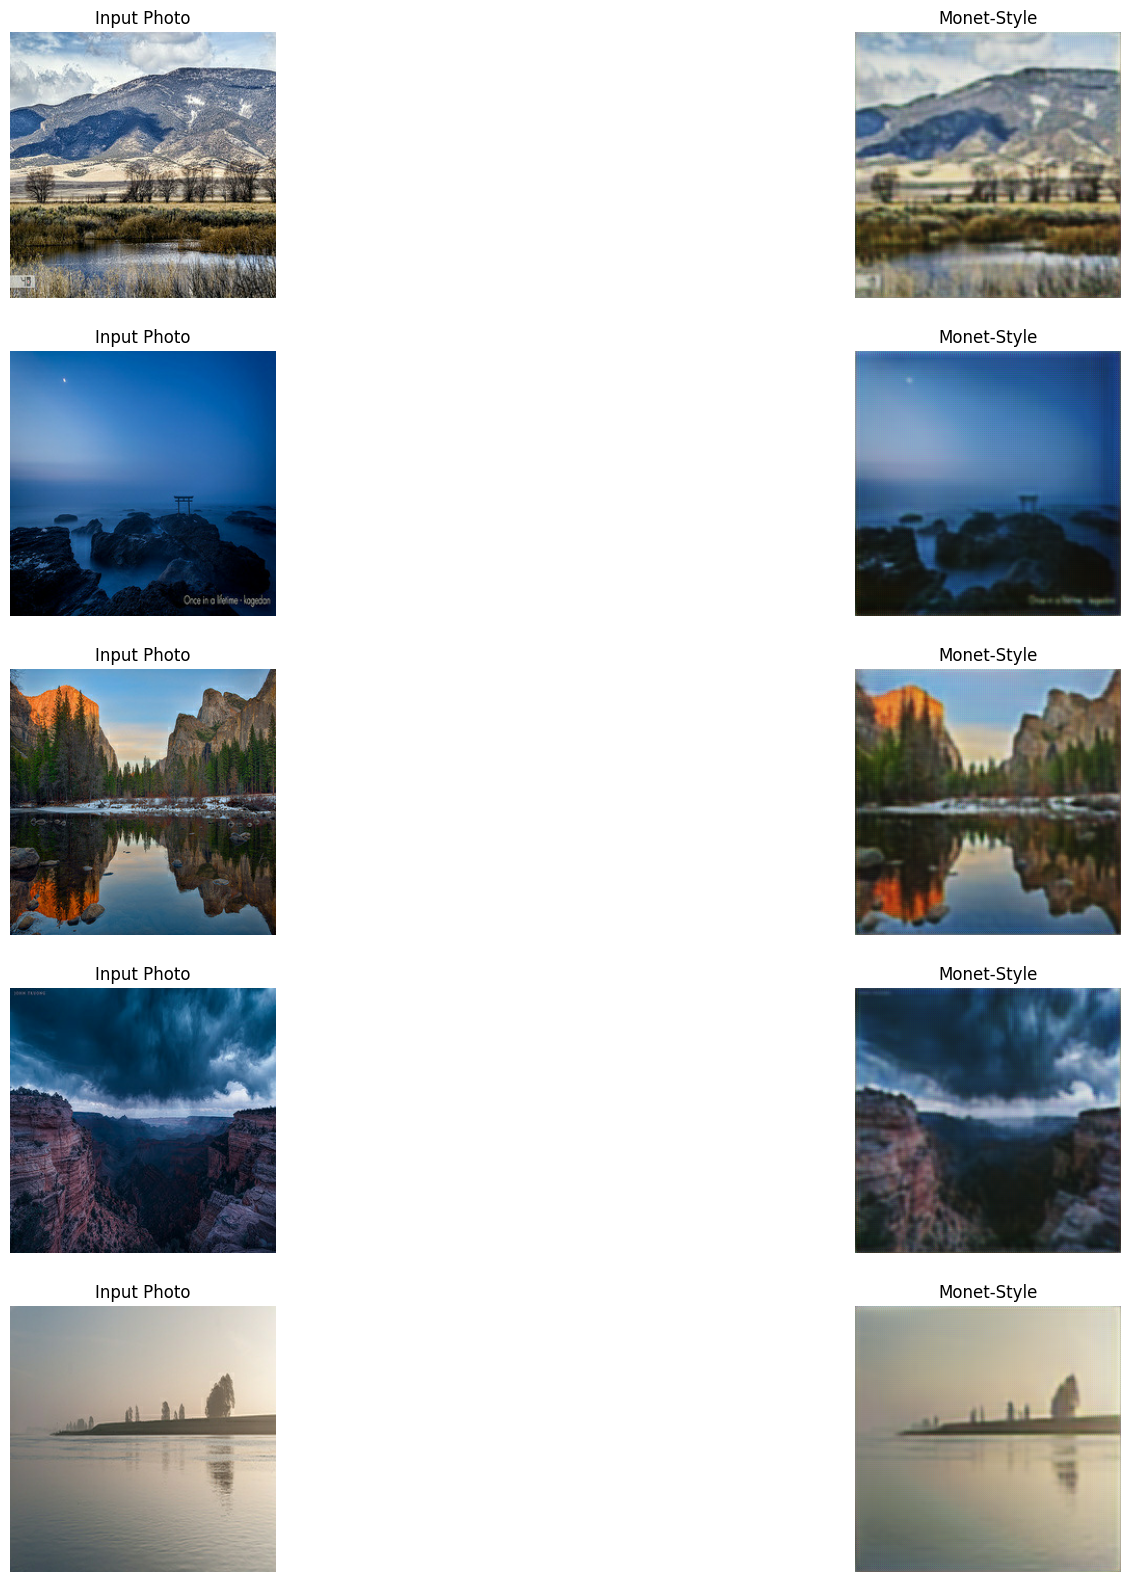

In [22]:
fig, ax = plt.subplots(5, 2, figsize=(20, 20))
for i, img in enumerate(photo_tfrec.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-Style")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

### Final analysis
Based on the pictures above the monet-style pictures start to take on a monet-style, but also look a bit blurry.  Running with more epoch would likely help finish that transformation.  Also, exploring adding more layers to the generator model could be interesting to review.  The Kaggle submission results in a score of ~79.18.

### Kaggle Submission
This section "predicts" creates output images and stores them in a zip file to get a score from Kaggle.

In [36]:
! mkdir ../images

i = 1
for img in photo_tfrec:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1
    

shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


mkdir: cannot create directory '../tmp': File exists


### Conclusion

#### References
- CycleGAN Model: https://machinelearningmastery.com/what-is-cyclegan/
- Help structuring the model from this GitHub Repo: https://github.com/yevi7113/Monet-Painting-CycleGAN/blob/main/monet-painting-cyclegan.ipynb
- General GAN Model support: https://keras.io/examples/generative/dcgan_overriding_train_step/